In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm, tree
from sklearn.ensemble import RandomForestRegressor
from  sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

np.random.seed(1907)

# Initial Predictions

In [2]:
def prepare_data(exclude_columns=None, features_to_use=None, apply_x_col=None):
    

    data = pd.read_csv("https://raw.githubusercontent.com/ahmetsirel/ozu_data_science/master/M5%20-%20General%20Linear%20Models/cell2cell-v1.csv")
    data.dropna(inplace= True)
    data = data.drop(["Unnamed: 0",	
                        "X",	
                        "customer",	
                        "traintest",
                        'churn', 
                        "churndep", 
                        'recchrge'], axis=1)
    
    if exclude_columns is not None and features_to_use is not None:
        raise Exception("exclude_columns and features_to_use cannot be used at the same time.")

    if exclude_columns is not None:
        data = data.drop(exclude_columns, axis=1)

    if features_to_use is not None:
        data = data[features_to_use + ["revenue"]]

    data = pd.get_dummies(data)

    x = data.drop('revenue', axis=1)
    
    y = data['revenue']

    if apply_x_col is not None:
        x = x.apply(apply_x_col)
    

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size = 0.25, random_state = 42)
    return x_train, x_test, y_train, y_test, data

In [3]:
x_train, x_test, y_train, y_test, data = prepare_data()

In [4]:
def scale_data(x_train, x_test, scaler=StandardScaler):

    scaler = scaler()
    scaler.fit(x_train)

    x_train_scaled = scaler.transform(x_train)
    x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)

    x_test_scaled = scaler.transform(x_test)
    x_test_scaled = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)

    x_train_scaled.fillna(x_train_scaled.mean(), inplace=True)
    x_test_scaled.fillna(x_test_scaled.mean(), inplace=True)

    return x_train_scaled, x_test_scaled



In [5]:
def evaluate_regression(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name="", model=None):   
    return pd.DataFrame.from_records([[
                                       metrics.mean_squared_error(y_true_train, y_pred_train),
                                       metrics.mean_absolute_error(y_true_train, y_pred_train),
                                       metrics.max_error(y_true_train, y_pred_train),
                                       metrics.r2_score(y_true_train, y_pred_train), 
                                      metrics.mean_squared_error(y_true_test, y_pred_test),
                                       metrics.mean_absolute_error(y_true_test, y_pred_test),
                                       metrics.max_error(y_true_test, y_pred_test),
                                       metrics.r2_score(y_true_test, y_pred_test),
                                       model]],
                                     
                                     index=[model_name], 
                                     columns=['mean_squared_error_train', 'mean_absolute_error_train', 'max_error_train', "r2_score_train",
                                              'mean_squared_error_test', 'mean_absolute_error_test', 'max_error_test', "r2_score_test", "model_object"])


In [6]:
def run_models(x_train, x_test, y_train, y_test):
        results = pd.DataFrame()
        for model in [linear_model.LinearRegression(), 
                        linear_model.RidgeCV(),
                        linear_model.LassoCV(),
                        svm.LinearSVR(),
                        #svm.SVR(kernel="rbf",),
                        #svm.SVR(kernel="poly"),
                        tree.DecisionTreeRegressor()]:
                #print(type(model).__name__, "Started")
                model.fit(x_train, y_train)
                #print(type(model).__name__, "Ended")
                y_train_pred = model.predict(x_train)
                y_test_pred = model.predict(x_test)

                results = results.append(evaluate_regression(y_train, y_train_pred, y_test, y_test_pred,
                                        model_name=type(model).__name__, model=model))
        return results


In [7]:
experiment_list = pd.DataFrame()
def run(exclude_columns=None, features_to_use=None, name="", apply_x_col=None):
    global experiment_list
    print(name)
    x_train, x_test, y_train, y_test, data = prepare_data(exclude_columns=exclude_columns, features_to_use=features_to_use, apply_x_col=apply_x_col)
    x_train, x_test = scale_data(x_train, x_test, scaler=StandardScaler)

    results = run_models(x_train, x_test, y_train, y_test)

    print("Min mean_squared_error_test Test",results.sort_values("mean_squared_error_test").iloc[0]["mean_squared_error_test"])

    best_model = results.sort_values("mean_squared_error_test").reset_index().loc[[0], ["mean_squared_error_train", "mean_squared_error_test", "index","model_object"]].rename({0:name, "index":"model_name"})
    if experiment_list is not None:
        experiment_list = experiment_list.append(best_model)

    return results.sort_values("mean_squared_error_test")

In [106]:
results = run(exclude_columns=None, name="Initial Run")

Initial Run
Min mean_squared_error_test Test 401.4432110070674


In [107]:
results

,mean_squared_error_train,mean_absolute_error_train,max_error_train,r2_score_train,mean_squared_error_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object
LassoCV,4.108938e+02,1.256996e+01,7.550257e+02,0.781958,401.443211,12.329446,511.888698,0.802745,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
RidgeCV,4.098249e+02,1.256842e+01,7.522860e+02,0.782526,401.923119,12.338010,511.966629,0.802509,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N..."
LinearRegression,4.098228e+02,1.256757e+01,7.526415e+02,0.782527,402.028255,12.337654,512.236275,0.802457,"LinearRegression(copy_X=True, fit_intercept=Tr..."
LinearSVR,4.257021e+02,1.223268e+01,9.225178e+02,0.774100,403.705445,11.945810,563.331400,0.801633,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i..."
DecisionTreeRegressor,3.716736e-32,1.046168e-17,3.552714e-15,1.000000,728.827678,16.919868,616.994995,0.641879,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


#  (i) variable interaction

In [108]:
corr = data.corr().unstack().reset_index(name='corr').rename(columns={'level_0': 'V1', 'level_1': 'V2'})
corr['corr_abs'] = np.abs(corr['corr'])
corr = corr[corr.V1 != corr.V2]
corr = corr.sort_values('corr_abs', ascending=False)
corr_with_label = corr[corr.V1 == "revenue"].copy()
corr['key'] = corr.apply(lambda x: str(sorted((x.V1, x.V2))) , axis=1)

corr = corr.drop_duplicates(subset='key').drop('key', axis=1)


len(corr)

2080

## Detect the columns with high correlation with each other and drop the one has lower corr with LABEL

In [109]:
corr_wide = corr.merge(corr_with_label[["V2","corr","corr_abs"]], left_on="V1", right_on="V2" , how="left", suffixes=(None, "_V1_corr_with_label")).drop("V2_V1_corr_with_label",axis=1).merge(corr_with_label[["V2","corr","corr_abs"]], left_on="V2", right_on="V2" , how="left", suffixes=(None, "_V2_corr_with_label"))#.drop("V2_V2_corr_with_label",axis=1)
corr_wide.head()

,V1,V2,corr,corr_abs,corr_V1_corr_with_label,corr_abs_V1_corr_with_label,corr_V2_corr_with_label,corr_abs_V2_corr_with_label
0,mailres,mailord,0.967441,0.967441,-0.091854,0.091854,-0.091035,0.091035
1,retcall,retcalls,0.955164,0.955164,0.016116,0.016116,0.016305,0.016305
2,models,phones,0.889208,0.889208,0.232018,0.232018,0.239804,0.239804
3,mourec,mou,0.829735,0.829735,0.608737,0.608737,0.710476,0.710476
4,creditcd,incmiss,-0.817948,0.817948,-0.084609,0.084609,0.072773,0.072773


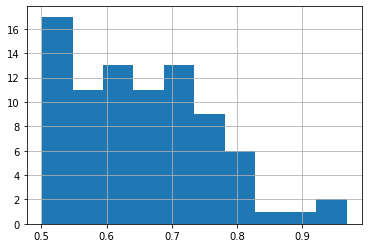

In [110]:
corr[corr.corr_abs >= 0.5].corr_abs.hist()

In [111]:
def columns_to_drop(row):
    if row.corr_abs_V1_corr_with_label > row.corr_abs_V2_corr_with_label:
        row["column_to_drop"] = row.V2 
        row["corr_with_label_column_to_drop"] = row.corr_abs_V2_corr_with_label
    
    else:
        row["column_to_drop"] = row.V1 
        row["corr_with_label_column_to_drop"] = row.corr_abs_V1_corr_with_label
    return row

corr_wide = corr_wide.apply(columns_to_drop, axis=1)
corr_wide.head()

,V1,V2,corr,corr_abs,corr_V1_corr_with_label,corr_abs_V1_corr_with_label,corr_V2_corr_with_label,corr_abs_V2_corr_with_label,column_to_drop,corr_with_label_column_to_drop
0,mailres,mailord,0.967441,0.967441,-0.091854,0.091854,-0.091035,0.091035,mailord,0.091035
1,retcall,retcalls,0.955164,0.955164,0.016116,0.016116,0.016305,0.016305,retcall,0.016116
2,models,phones,0.889208,0.889208,0.232018,0.232018,0.239804,0.239804,models,0.232018
3,mourec,mou,0.829735,0.829735,0.608737,0.608737,0.710476,0.710476,mourec,0.608737
4,creditcd,incmiss,-0.817948,0.817948,-0.084609,0.084609,0.072773,0.072773,incmiss,0.072773


In [112]:
columns_to_drop_high_corr = corr_wide[(corr_wide.corr_abs >= 0.8) ].column_to_drop.unique().tolist()
columns_to_drop_high_corr

['mailord', 'retcall', 'models', 'mourec', 'incmiss', 'blckvce']

## Columns with low corr. with the label columns.

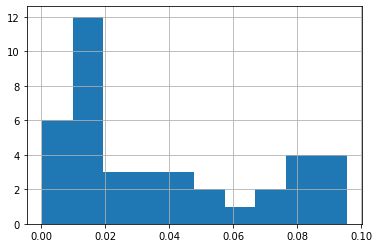

In [113]:
corr_with_label[corr_with_label.corr_abs<0.1].corr_abs.hist()

In [114]:
columns_to_drop_low_corr_with_label = corr_with_label[corr_with_label.corr_abs<0.1].V2.unique().tolist()
columns_to_drop_low_corr_with_label

['age2',
 'marryyes',
 'mailres',
 'mailord',
 'creditcd',
 'ownrent',
 'pcown',
 'income',
 'marryun',
 'incmiss',
 'occprof',
 'children',
 'credita',
 'refurb',
 'actvsubs',
 'travel',
 'truck',
 'occret',
 'newcelln',
 'prizmtwn',
 'mailflag',
 'prizmub',
 'retaccpt',
 'newcelly',
 'retcalls',
 'occcler',
 'retcall',
 'prizmrur',
 'months',
 'changem',
 'refer',
 'uniqsubs',
 'occcrft',
 'rv',
 'occself',
 'occstud',
 'occhmkr',
 'mcycle',
 'callfwdv',
 'changer']

In [115]:
columns_to_use_high_corr_with_label = corr_with_label[corr_with_label.corr_abs>0.6].V2.unique().tolist()
columns_to_use_high_corr_with_label

['overage', 'mou', 'peakvce', 'mourec']

## Experiments

In [116]:
run(exclude_columns=columns_to_drop_high_corr, name="Drop high corr. columns.")


Drop high corr. columns.
Min mean_squared_error_test Test 399.3731435054334


,mean_squared_error_train,mean_absolute_error_train,max_error_train,r2_score_train,mean_squared_error_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object
RidgeCV,4.106825e+02,1.257720e+01,7.657769e+02,0.782071,399.373144,12.343760,498.632589,0.803762,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N..."
LinearRegression,4.106824e+02,1.257667e+01,7.660970e+02,0.782071,399.393828,12.343208,498.983772,0.803752,"LinearRegression(copy_X=True, fit_intercept=Tr..."
LassoCV,4.117931e+02,1.258003e+01,7.675485e+02,0.781481,399.902816,12.334377,500.508464,0.803502,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
LinearSVR,4.274165e+02,1.224283e+01,9.406132e+02,0.773191,402.684479,11.948599,555.454010,0.802135,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i..."
DecisionTreeRegressor,5.099707e-32,1.143486e-17,7.105427e-15,1.000000,759.007111,17.101454,607.130005,0.627050,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


In [117]:
run(exclude_columns=columns_to_drop_low_corr_with_label, name="Drop low corr. columns.")

Drop low corr. columns.
Min mean_squared_error_test Test 404.68557335425487


,mean_squared_error_train,mean_absolute_error_train,max_error_train,r2_score_train,mean_squared_error_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object
LassoCV,413.170673,12.590692,757.745704,0.780750,404.685573,12.356681,513.048427,0.801152,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
RidgeCV,412.859476,12.584193,756.461642,0.780915,405.371113,12.354377,512.479706,0.800815,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N..."
LinearRegression,412.857460,12.583245,756.823241,0.780916,405.461911,12.353750,512.746637,0.800770,"LinearRegression(copy_X=True, fit_intercept=Tr..."
LinearSVR,427.803255,12.295384,928.282627,0.772985,413.010816,12.010780,570.297030,0.797061,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i..."
DecisionTreeRegressor,0.015614,0.001722,10.156250,0.999992,785.622775,17.634702,618.624985,0.613972,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


In [118]:
run(exclude_columns=list(set(columns_to_drop_high_corr+columns_to_drop_low_corr_with_label)), name="Drop both high corr. with other columns and low corr. with label.")

Drop both high corr. with other columns and low corr. with label.
Min mean_squared_error_test Test 402.69883561850094


,mean_squared_error_train,mean_absolute_error_train,max_error_train,r2_score_train,mean_squared_error_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object
LassoCV,413.739233,12.596211,770.891305,0.780449,402.698836,12.358114,501.132806,0.802128,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
RidgeCV,413.581018,12.595147,769.709027,0.780532,403.037842,12.362447,499.771101,0.801961,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N..."
LinearRegression,413.580874,12.594590,770.031303,0.780533,403.056143,12.361839,500.123612,0.801952,"LinearRegression(copy_X=True, fit_intercept=Tr..."
LinearSVR,428.984070,12.304404,945.318241,0.772359,411.782437,12.014093,564.726560,0.797664,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i..."
DecisionTreeRegressor,0.015614,0.001722,10.156250,0.999992,826.615647,17.901264,618.624985,0.593830,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


In [119]:
result = run(features_to_use=columns_to_use_high_corr_with_label, name="High corr. columns with label.")

High corr. columns with label.
Min mean_squared_error_test Test 598.6828617529472


In [120]:
result

,mean_squared_error_train,mean_absolute_error_train,max_error_train,r2_score_train,mean_squared_error_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object
LinearRegression,493.633252,13.888799,833.525493,0.738053,598.682862,13.819134,804.823231,0.705828,"LinearRegression(copy_X=True, fit_intercept=Tr..."
RidgeCV,493.633403,13.889437,833.058056,0.738053,598.728141,13.819923,804.842776,0.705806,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N..."
LassoCV,493.658881,13.895175,829.367382,0.738039,599.516509,13.827429,805.086388,0.705418,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
LinearSVR,510.619553,13.534339,974.751704,0.729039,612.304989,13.359244,813.508545,0.699135,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i..."
DecisionTreeRegressor,9.240639,0.443157,90.070152,0.995096,941.572020,19.483960,784.357483,0.537344,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


## Result

In [121]:
experiment_list.sort_values("mean_squared_error_test")

,mean_squared_error_train,mean_squared_error_test,index,model_object
Drop high corr. columns.,410.682517,399.373144,RidgeCV,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N..."
Initial Run,410.893788,401.443211,LassoCV,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
Drop both high corr. with other columns and low corr. with label.,413.739233,402.698836,LassoCV,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
Drop low corr. columns.,413.170673,404.685573,LassoCV,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
High corr. columns with label.,493.633252,598.682862,LinearRegression,"LinearRegression(copy_X=True, fit_intercept=Tr..."


# (ii) variable transformation

# Outlier handling

## Tukey’s box plot method

In [122]:
def calculate_outlier_limits_tukeys(x, level="high"):
    x_desc = x.describe().T

    x_desc["IQR"] = x_train_desc["75%"] - x_train_desc["25%"]

    x_desc["LOWER_OUTER_FENCE"] = x_desc["25%"] - 3 * x_desc["IQR"]
    x_desc["LOWER_INNER_FENCE"] = x_desc["25%"] - 1.5 * x_desc["IQR"]
    x_desc["UPPER_INNER_FENCE"] = x_desc["75%"] + 1.5 * x_desc["IQR"]
    x_desc["UPPER_OUTER_FENCE"] = x_desc["75%"] + 3 * x_desc["IQR"]
    
    if level=="high":
        x_desc = x_desc.rename({"LOWER_INNER_FENCE":"lower_boundry",
                                "UPPER_INNER_FENCE":"upper_boundry"},axis=1)
    elif level=="low":
        x_desc = x_desc.rename({"LOWER_OUTER_FENCE":"lower_boundry",
                                "UPPER_OUTER_FENCE":"upper_boundry"},axis=1)

    return x_desc[["lower_boundry", "upper_boundry"]]

In [123]:
def trim_data(column, limits):
    try:
        l = limits.loc[column.name,:]
        column = column.mask(column > l.upper_boundry, l.upper_boundry)
        column = column.mask(column < l.lower_boundry, l.lower_boundry)

        return column

    except Exception as e:
        return column
    

In [124]:
limits = calculate_outlier_limits_tukeys(x_train)
mask_outliers_tukeys = lambda column: trim_data(column, limits= limits)

In [125]:
result = run(exclude_columns=columns_to_drop_high_corr, apply_x_col= mask_outliers_tukeys,
                name="Drop high corr. columns. + Mask outliers")


Drop high corr. columns. + Mask outliers
Min mean_squared_error_test Test 905.1936632865503


In [126]:
experiment_list

,mean_squared_error_train,mean_squared_error_test,index,model_object
Initial Run,410.893788,401.443211,LassoCV,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
Drop high corr. columns.,410.682517,399.373144,RidgeCV,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N..."
Drop low corr. columns.,413.170673,404.685573,LassoCV,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
Drop both high corr. with other columns and low corr. with label.,413.739233,402.698836,LassoCV,"LassoCV(alphas=None, copy_X=True, cv=None, eps..."
High corr. columns with label.,493.633252,598.682862,LinearRegression,"LinearRegression(copy_X=True, fit_intercept=Tr..."
Drop high corr. columns. + Mask outliers,795.962801,905.193663,LinearRegression,"LinearRegression(copy_X=True, fit_intercept=Tr..."


# (iii)multi-collinearity issues

# (iv) feature elimination & selection

# (v) model selection